# RAM usage

Measuring and estimating RAM usage of `emg3d` as a function of model size.

In [1]:
import emg3d
import numpy as np
import matplotlib.pyplot as plt

%load_ext memory_profiler

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.matplotlib.rcParams['figure.dpi'] = 300
plt.matplotlib.rcParams['savefig.dpi'] = 300

In [3]:
def get_field_and_model_size(grid):
    """Estimate size of fields and model parameters."""

    # 8 Byte per float.
    nbytes = 8

    # Size of electric field, source field, and residual field (MB):
    size_fields = grid.nE*nbytes*2  # 2x because complex
    size_fields *= 3                # efield, sfield, pfield

    # Size of model parameters (MB); isotropic case:
    size_params = grid.nC*nbytes
    size_params *= 4  # res (1x), mu (1x), eta (x2 because complex)
    
    total_size = size_fields + size_params
    
    return total_size/1e6  # => MB
    
def calculate(nx, base=True):

    # Grid
    hx = np.ones(nx)*50
    x0 = -nx//2*50
    grid = emg3d.utils.TensorMesh([hx, hx, hx], x0=(x0, x0, x0))

    # Source location and frequency
    src = [0, 0, 0, 0, 0] 
    freq = 1.0
    
    total_size = get_field_and_model_size(grid)
    
    # Model and source field
    model = emg3d.utils.Model(grid, 1., freq=freq)
    sfield = emg3d.utils.get_source_field(grid, src, freq=freq, strength=0)

    # Calculate the field
    if base:
        efield = emg3d.solver.solver(
            grid, model, sfield, maxit=1, verb=1,
            nu_init=0, nu_pre=0, nu_coarse=1, nu_post=0, clevel=0)
    else:
        efield = emg3d.solver.solver(grid, model, sfield, maxit=1, verb=1)
    
    return total_size

In [4]:
nsizes = np.array([64, 96, 128, 192, 256, 384, 512, 768, 1024])
run_mem = np.zeros(nsizes.shape)
base_mem = np.zeros(nsizes.shape)
dat_mem = np.zeros(nsizes.shape)

for i, nx in enumerate(nsizes):
    print(f"  == {nx}^3 ~ {nx**3:4.2e} cells ==\n")
    
    mem1 = %memit -r 1 -o -q total_size = calculate(nx, True)
    base_mem[i] = mem1.mem_usage[0]
    dat_mem[i] = total_size
    
    print(f"  RAM req. for data:   {dat_mem[i]:5.0f} MB")
    print(f"  RAM used by base MG: {base_mem[i]:5.0f} MB")

    mem2 = %memit -r 1 -o -q total_size = calculate(nx, False)
    run_mem[i] = mem2.mem_usage[0]
    
    print(f"  RAM used by full MG: {run_mem[i]:5.0f} MB\n")
    
    print(f"  Factor full/base: {run_mem[i]/base_mem[i]:6.2f}")
    print(f"  Factor full/data: {run_mem[i]/dat_mem[i]:6.2f}\n")

  == 64^3 ~ 2.62e+05 cells ==

  RAM req. for data:      47 MB
  RAM used by base MG:   170 MB
  RAM used by full MG:   212 MB

  Factor full/base:   1.25
  Factor full/data:   4.49

  == 96^3 ~ 8.85e+05 cells ==

  RAM req. for data:     158 MB
  RAM used by base MG:   336 MB
  RAM used by full MG:   379 MB

  Factor full/base:   1.13
  Factor full/data:   2.39

  == 128^3 ~ 2.10e+06 cells ==

  RAM req. for data:     374 MB
  RAM used by base MG:   570 MB
  RAM used by full MG:   678 MB

  Factor full/base:   1.19
  Factor full/data:   1.81

  == 192^3 ~ 7.08e+06 cells ==

  RAM req. for data:    1256 MB
  RAM used by base MG:  1397 MB
  RAM used by full MG:  1821 MB

  Factor full/base:   1.30
  Factor full/data:   1.45

  == 256^3 ~ 1.68e+07 cells ==

  RAM req. for data:    2972 MB
  RAM used by base MG:  3047 MB
  RAM used by full MG:  4035 MB

  Factor full/base:   1.32
  Factor full/data:   1.36

  == 384^3 ~ 5.66e+07 cells ==

  RAM req. for data:   10008 MB
  RAM used by base

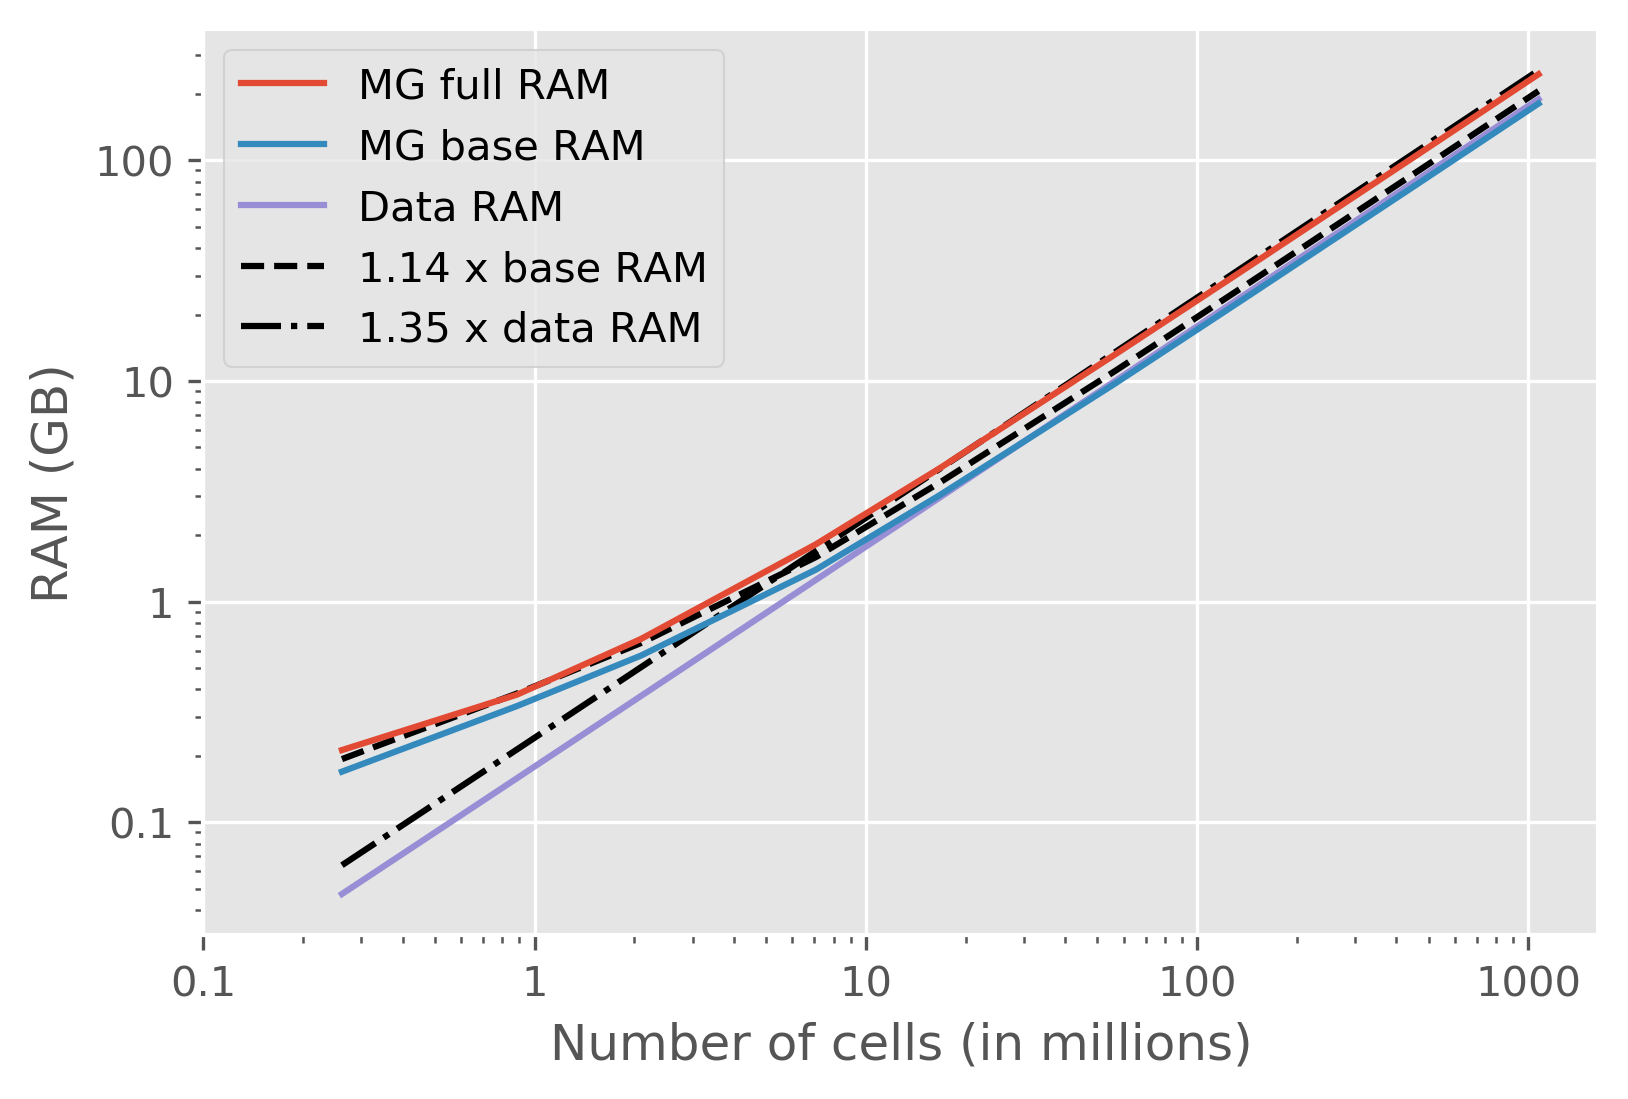

In [5]:
plt.figure()
plt.loglog(nsizes**3/1e6, run_mem/1e3, '-', zorder=10, label='MG full RAM')
plt.loglog(nsizes**3/1e6, base_mem/1e3, '-', zorder=9, label='MG base RAM')
plt.loglog(nsizes**3/1e6, dat_mem/1e3, '-', zorder=8, label='Data RAM')
plt.loglog(nsizes**3/1e6, 1.14*base_mem/1e3, 'k--', label='1.14 x base RAM')
plt.loglog(nsizes**3/1e6, 1.35*dat_mem/1e3, 'k-.', label='1.35 x data RAM')
plt.legend()
plt.xlabel('Number of cells (in millions)')
plt.ylabel('RAM (GB)')
plt.xticks([1e-1, 1e0, 1e1, 1e2, 1e3], ('0.1', '1', '10', '100', '1000'))
plt.yticks([1e-1, 1e0, 1e1, 1e2], ('0.1', '1', '10', '100'))
plt.savefig('RAM-Usage.svg', facecolor='none', edgecolor='none', bbox_inches='tight')
plt.show()

In [6]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Fri Jul 05 13:28:24 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.6 GB : RAM
           Jupyter : Environment

  Python 3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC 7.3.0]

            1.16.4 : numpy
             1.2.1 : scipy
            0.44.1 : numba
             0.7.0 : emg3d
             7.6.0 : IPython
             3.1.0 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------